---
title: "Анализ клиентской базы крупного онлайн-маркетплейса и стратегии увеличения LTV (Customer Lifetime Value) за 2023 год"
subtitle: "В данном анализе проводится детальный обзор данных клиентской базы за 2023 год с целью выявления ключевых метрик и возможностей для увеличения LTV (Customer Lifetime Value). На основе анализа данных предлагаются стратегии и рекомендации по улучшению клиентского опыта, увеличению частоты покупок и продлению срока жизни клиентов. В результате анализа также строятся необходимые графики для визуализации данных."
author: Ekaterina
echo: False
format:
    pdf:
        documentclass: report
        mainfont: "Times New Roman"
        code-fold: true
keep-inpynb: true
---

In [13]:
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import gdown
pio.templates.default = "plotly_white"

In [14]:
url = 'https://drive.google.com/file/d/1aTq3ZGa7nn7cqmUV724lbZ-5ieBG9QTt/view?usp=sharing'

output = 'online_marketplace_sales.csv'
gdown.download(url, output, quiet=False, fuzzy=True)

df = pd.read_csv(output, parse_dates=["purchase_datetime"])

Downloading...
From (original): https://drive.google.com/uc?id=1aTq3ZGa7nn7cqmUV724lbZ-5ieBG9QTt
From (redirected): https://drive.google.com/uc?id=1aTq3ZGa7nn7cqmUV724lbZ-5ieBG9QTt&confirm=t&uuid=f4c8a80a-3837-4e1c-b64d-21cc35ea0b31
To: D:\SynologyDrive\Ekaterina\My\Python\personal\online_marketplace_sales\analytics\online_marketplace_sales.csv
100%|██████████| 143M/143M [00:20<00:00, 6.84MB/s] 


## Анализ пользовательского поведения по времени суток 

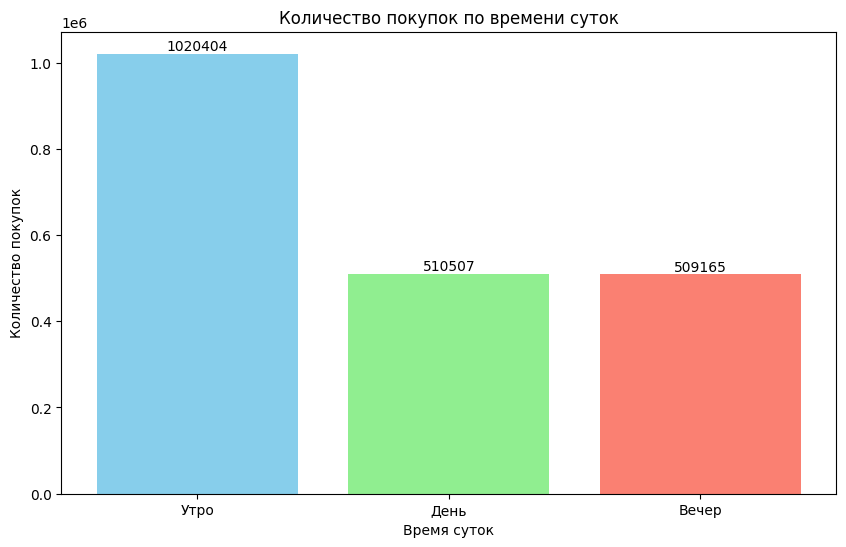

In [15]:
# Преобразование времени в часы
df['purchase_time_as_seconds_from_midnight'] = pd.to_timedelta(df['purchase_time_as_seconds_from_midnight'], unit='s')

# Определение времени суток
def determine_time_of_day(seconds):
    if 0 <= seconds < 43200:
        return 'Утро'
    elif 43200 <= seconds < 64800:
        return 'День'
    else:
        return 'Вечер'

df['time_of_day'] = df['purchase_time_as_seconds_from_midnight'].dt.total_seconds().apply(determine_time_of_day)

# Подсчет количества покупок для каждого времени суток
purchase_count = df['time_of_day'].value_counts().reset_index()
purchase_count.columns = ['time_of_day', 'purchase_count']

# Визуализация результатов
plt.figure(figsize=(10, 6))
bars = plt.bar(purchase_count['time_of_day'], purchase_count['purchase_count'], color=['skyblue', 'lightgreen', 'salmon'])

# Добавление цифр на столбцы
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.title('Количество покупок по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Количество покупок')
plt.show()

Анализ данных показывает, что объем покупок в первой половине дня (до 12:00) значительно выше в два раза по сравнению с последующими часами. Это может быть связано с особенностями поведения клиентов, их графиком работы и доступностью маркетинговых предложений.

Чтобы стимулировать продажи во второй половине дня, стоит рассмотреть несколько стратегий:

1. Запуск "Обеденных" и "Вечерних" промо-акций
- **Специальные скидки с 12:00 до 16:00** для привлечения покупателей в дневной спад.

- **Акции "вечерние бонусы" (с 18:00 до 22:00)** для стимулирования покупок в конце дня.

- **Флеш-скидки (кратковременные акции на 2-3 часа)** → создают ощущение срочности.
2. Персонализированные пуш-уведомления
- Отправка **напоминаний о товарах** в корзине во второй половине дня.

- Использование предиктивной аналитики для **персонализированных рекомендаций** товаров.
3. Игровые механики и "счастливые часы"
- Геймификация: **кешбэк за покупки во второй половине дня**.

- **Программы лояльности**, повышающие кэшбэк или бонусы при покупках после 12:00.

## Rolling Retention

**Rolling Retention** — это показатель, отражающий процент пользователей от первоначального количества, которые продолжают пользоваться продуктом спустя N дней после первого взаимодействия. При этом учитываются как пользователи, совершившие действие в точный день N, так и те, кто вернулся в любой день позже.

Этот метод расчета был выбран вместо стандартного Retention Rate, поскольку маркетплейс не предполагает ежедневных покупок, как, например, продуктовый магазин. В данном случае важно не то, чтобы клиент совершал покупку в строго определенный день, а то, чтобы он в принципе возвращался за покупками в будущем.

In [16]:
def calculate_rolling_retention(df: pd.DataFrame, days: list) -> list:
  
    # Рассчитываем начальные даты для каждого пользователя и объединяем их с исходным DataFrame
    start_date = df.groupby('client_id')['purchase_datetime'].min().rename("start_date")
    df = pd.merge(df, start_date, left_on='client_id', right_index=True)
    
    # Рассчитываем количество дней от начальной даты для каждой строки
    df['day'] = (df['purchase_datetime'] - df['start_date']).dt.days
    
    # Создаем список для хранения rolling retention на каждый день
    rolling_retention = []
    
    # Рассчитываем rolling retention для каждого дня
    for day in days:

        # Выбираем пользователей, вернувшихся в день `day` или позже
        users_with_rolling_day = df[df['day'] >= day]['client_id'].unique()
        
        # Рассчитываем rolling retention для данного дня
        rolling_retention.append(len(users_with_rolling_day) / len(df['client_id'].unique()))
    
    return rolling_retention

In [17]:
import matplotlib.ticker as mtick

def plt_show(days: list, retention: list, xs: list, title: str):
    plt.figure(figsize=(16, 6))
    plt.plot(days, retention)

    plt.title(title)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.gca().set_xlabel('Days', fontsize=15)
    plt.gca().set_ylabel('% Retaining Users', fontsize=15)
    plt.ylim(0, 1.05)

    for x in xs:
        plt.vlines(x=days[x], ymin=0, ymax=retention[x], linestyles='dotted')
        plt.text(x=days[x], y=retention[x] + 0.05, s='{:.0%} (day {})'.format(retention[x], x), fontsize=12)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)
    plt.show()

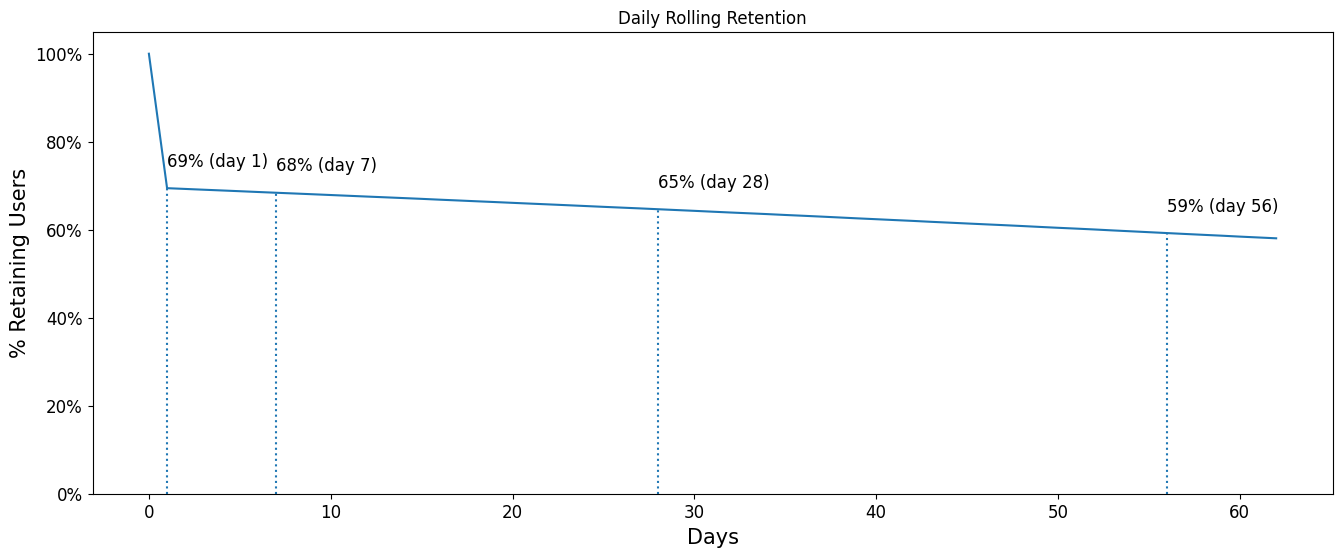

In [18]:
days = list(range(0, 63))
rolling_retention = calculate_rolling_retention(df, days)

plt_show(days, rolling_retention, xs=[1, 7, 28, 56], title='Daily Rolling Retention')

### Выводы по Rolling Retention

1. Высокий Retention на первых этапах:

- 69% пользователей возвращаются уже на следующий день, что говорит о хорошем первом впечатлении продукта.

- Снижение до 68% на 7 день незначительно, что указывает на устойчивую лояльность клиентов.

2. Постепенное уменьшение удержания:

- К 28 дню retention падает до 65%, а к 56 дню до 59%. Это нормальный тренд, но важно понимать, какие сегменты пользователей перестают возвращаться и почему.

3. Уровень удержания через 2 месяца остается довольно высоким:

- Падение retention не критично, но улучшить его можно через стратегическое воздействие на повторные покупки.

**Стоит ли повышать Rolling Retention?**

Да, но **не просто ради цифр**, а с учетом бизнес-целей:

- Если marketplace ориентирован на разовые или редкие покупки, то текущий retention уже достаточно хороший.

- Если платформа зарабатывает на повторных заказах и активности клиентов, то стоит проработать стратегии повышения.

### Предложения как повысить метрику

- Персонализация предложений: рекомендации на основе истории покупок, push-уведомления c релевантными предложениями через некоторое время после первой покупки.

- Программы лояльности: бонусы за покупки, привилегии и т.п

- Маркетинговые кампании: таргетированная реклама, email-маркетинг

- Анализ: определить сегмент пользователей, которые перестают возвращаться после определенного времени

## Итог анализа клиентской базы

Пользователи активно совершают покупки, но есть потенциал для улучшения ключевых метрик. В частности, показатель LTV (Lifetime Value) можно повысить за счет увеличения Retention Rate и AOV (среднего чека).

**Как повысить AOV?**

1. Рекомендации сопутствующих товаров

- Предлагать товары, которые логично дополняют покупку (например, аксессуары к основному товару).

2. Увеличение минимального порога для скидки

- Бесплатная доставка при заказе от определенной суммы.

- Скидка на следующий заказ, если текущая покупка превышает установленный порог.

3. Программы лояльности и бонусы

- Кэшбэк за более дорогие заказы.

- VIP-статус для клиентов с высокими тратами, дающий доступ к эксклюзивным скидкам.

4. Психологические триггеры

- "Последние единицы в наличии" → стимулирует срочные покупки.

- "Скидка действует только сегодня" → побуждает клиента действовать быстрее.

- Рекомендации на основе предыдущих покупок → персонализированный подход к клиенту.

5. Улучшение UX и удобства покупки

- Легкость оформления заказа.

- Быстрые платежи и удобные варианты доставки.

**Вывод**

Повышение Retention Rate и AOV напрямую влияет на рост LTV. Внедрение перечисленных стратегий поможет увеличить средний чек и частоту повторных покупок, что приведет к устойчивому развитию клиентской базы и увеличению общей выручки.